In [133]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
import uuid

from pathlib import Path
from typing import Dict

In [134]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))


yaml.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)

In [135]:
OUTPUT_DIR = f"{Path.cwd()}/benchmark_output"
PREFILL_TRACE_FILE = f"{Path.cwd()}/prefill_operation_time_split_experiment_trace.csv"
MODEL_NAME = "01-ai/Yi-34B-200K"
MODEL_TP_DIMENSION = 2
# MODEL_NAME = "meta-llama/Llama-2-70b-hf"
# MODEL_TP_DIMENSION = 4

SEQUENCE_LENGTHS = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
PREFILL_EXPERIMENT_BATCH_SIZE = 1
NUM_REQUESTS_PER_SEQUENCE_LENGTH = 1

MAX_SEQUENCE_LENGTH = 1024
NUM_DECODE_TOKENS = 4
DECODE_BATCH_SIZES = [1, 2, 4, 8, 16, 32, 64, 128]

WANDB_PROJECT = "llm-simulator"
WANDB_GROUP = "vllm_operation_time_split_experiment"

In [136]:
def generate_trace_file_for_prefill_experiment():
    with open(PREFILL_TRACE_FILE, "w") as prefill_experiment_trace_file:
        prefill_experiment_trace_file.write(
            "num_prefill_tokens,num_decode_tokens,num_total_tokens,pd_ratio\n"
        )
        for sequence_length in SEQUENCE_LENGTHS:
            for _ in range(NUM_REQUESTS_PER_SEQUENCE_LENGTH):
                prefill_experiment_trace_file.write(
                    f"{sequence_length},1,{sequence_length},{sequence_length}\n"
                )

In [137]:
def _get_random_suffix():
    return str(uuid.uuid4()).split("-")[0]

In [138]:
def generate_runs():
    devices = ",".join([str(x) for x in range(MODEL_TP_DIMENSION)])
    generate_trace_file_for_prefill_experiment()
    prefill_experiment_run_name = f"{MODEL_NAME.split('/')[-1]}_tp_{MODEL_TP_DIMENSION}_prefill_split_{_get_random_suffix()}"
    command = (
        f"CUDA_VISIBLE_DEVICES={devices} python sarathi/benchmark/main.py \\\n"
        f"--output_dir {OUTPUT_DIR} \\\n"
        f"--model_name {MODEL_NAME} \\\n"
        f"--model_max_model_len {max(SEQUENCE_LENGTHS) + 1} \\\n"
        f"--cluster_num_replicas 1 \\\n"
        f"--model_tensor_parallel_degree {MODEL_TP_DIMENSION} \\\n"
        f"--model_pipeline_parallel_degree 1 \\\n"
        f"--request_generator_provider synthetic \\\n"
        f"--synthetic_request_generator_length_provider synthetic \\\n"
        f"--synthetic_request_generator_length_provider trace \\\n"
        f"--synthetic_request_generator_interval_provider static \\\n"
        f"--trace_request_length_generator_trace_file {PREFILL_TRACE_FILE} \\\n"
        f"--trace_request_length_generator_max_tokens {max(SEQUENCE_LENGTHS) + 1} \\\n"
        f"--trace_request_length_generator_prefill_scale_factor 1 \\\n"
        f"--trace_request_length_generator_decode_scale_factor 1 \\\n"
        f"--synthetic_request_generator_num_requests {NUM_REQUESTS_PER_SEQUENCE_LENGTH * len(SEQUENCE_LENGTHS)} \\\n"
        f"--metrics_store_keep_individual_batch_metrics true \\\n"
        f"--replica_scheduler_provider vllm \\\n"
        f"--replica_scheduler_max_batch_size 1 \\\n"
        f"--vllm_scheduler_max_tokens_in_batch {max(SEQUENCE_LENGTHS) + 1} \\\n"
        f"--metrics_store_wandb_project {WANDB_PROJECT} \\\n"
        f"--metrics_store_wandb_group {WANDB_GROUP} \\\n"
        f"--metrics_store_wandb_run_name {prefill_experiment_run_name} \\\n"
    )
    commands = [
        command + f"--metrics_store_enable_op_level_metrics false \n",
        command + f"--metrics_store_enable_op_level_metrics true \n",
    ]
    for batch_size in DECODE_BATCH_SIZES:
        decode_run_name = f"{MODEL_NAME.split('/')[-1]}_tp_{MODEL_TP_DIMENSION}_seq_len_{MAX_SEQUENCE_LENGTH}_decode_batch_size_{batch_size}_decode_split_{_get_random_suffix()}"

        command = (
            f"CUDA_VISIBLE_DEVICES={devices} python sarathi/benchmark/main.py \\\n"
            f"--output_dir {OUTPUT_DIR} \\\n"
            f"--model_name {MODEL_NAME} \\\n"
            f"--model_max_model_len {MAX_SEQUENCE_LENGTH} \\\n"
            f"--cluster_num_replicas 1 \\\n"
            f"--model_tensor_parallel_degree {MODEL_TP_DIMENSION} \\\n"
            f"--model_pipeline_parallel_degree 1 \\\n"
            f"--request_generator_provider synthetic \\\n"
            f"--synthetic_request_generator_length_provider synthetic \\\n"
            f"--synthetic_request_generator_length_provider uniform \\\n"
            f"--synthetic_request_generator_interval_provider static \\\n"
            f"--uniform_request_length_generator_prefill_to_decode_ratio {MAX_SEQUENCE_LENGTH / NUM_DECODE_TOKENS - 1} \\\n"
            f"--uniform_request_length_generator_min_tokens {MAX_SEQUENCE_LENGTH} \\\n"
            f"--uniform_request_length_generator_max_tokens {MAX_SEQUENCE_LENGTH} \\\n"
            f"--synthetic_request_generator_num_requests {2 * batch_size} \\\n"
            f"--metrics_store_keep_individual_batch_metrics true \\\n"
            f"--replica_scheduler_provider vllm \\\n"
            f"--replica_scheduler_max_batch_size {batch_size} \\\n"
            f"--vllm_scheduler_max_tokens_in_batch {MAX_SEQUENCE_LENGTH} \\\n"
            f"--metrics_store_wandb_project {WANDB_PROJECT} \\\n"
            f"--metrics_store_wandb_group {WANDB_GROUP} \\\n"
            f"--metrics_store_wandb_run_name {decode_run_name} \\\n"
        )
        commands.append(command + f"--metrics_store_enable_op_level_metrics false \n")
        commands.append(command + f"--metrics_store_enable_op_level_metrics true \n")

    with open(f"operation_time_split_runs.sh", "w") as f:
        f.write("#!/bin/bash\n")
        f.write("set -x\n")
        for command in commands:
            f.write(command + "\n")

In [139]:
def _get_run_directories():
    rootdir = Path(OUTPUT_DIR)
    subdirectory_list = [
        directory for directory in rootdir.iterdir() if directory.is_dir()
    ]
    return sorted(subdirectory_list)

In [140]:
def _get_df_for_single_run(
    config: Dict[str, object],
    benchmark_config: Dict[str, object],
    batch_metrics: pd.DataFrame,
    operation_metrics: pd.DataFrame,
    batch_num_prefill_tokens: int,
    batch_num_decode_tokens: int,
    batch_num_tokens: int,
):
    df = batch_metrics.copy()
    # df = pd.merge(batch_metrics, operation_metrics, on=["Batch Id"], how="inner")

    # print(len(df))
    df = df[
        (df["batch_num_tokens"] == batch_num_tokens)
        & (df["batch_num_prefill_tokens"] == batch_num_prefill_tokens)
        & (df["batch_num_decode_tokens"] == batch_num_decode_tokens)
    ]

    df["operation"] = "batch_execution_time"
    df["operation_time_per_token"] = (df["batch_execution_time"] * 1000) / df[
        "batch_num_tokens"
    ]
    # print(df)
    return df

    # datapoints = df.to_dict('records')
    # final_datapoints = []
    # for datapoint in datapoints:
    #     point = datapoint.copy()
    #     linear_time = point["mlp_up_proj"] + point["mlp_down_proj"] + point["attn_pre_proj"] + point["attn_post_proj"]
    #     attention_time = point["attn_prefill"] + point["attn_decode"]
    #     communication_time = point["mlp_up_proj_all_gather"] + point["mlp_down_proj_all_reduce"] + point["attn_pre_proj_all_gather"] + point["attn_post_proj_all_reduce"] + point["embed_all_reduce"]
    #     others_time = point["model_compute_time"] - linear_time - attention_time - communication_time
    #     final_datapoints.extend([
    #         { **point, "operation": "linear", "operation_time": linear_time },
    #         { **point, "operation": "communication", "operation_time": communication_time },
    #         { **point, "operation": "attention", "operation_time": attention_time },
    #         { **point, "operation": "others", "operation_time": others_time },
    #     ])
    # return pd.DataFrame(final_datapoints)

In [141]:
def _get_df():
    run_directories = _get_run_directories()
    run_directories.sort()

    # num_runs = 2 * (len(DECODE_BATCH_SIZES) + 1)
    # run_directories = run_directories[-num_runs:]

    prefill_dfs = []
    decode_dfs = []
    yaml.SafeLoader.add_constructor("tag:yaml.org,2002:python/tuple", tuple_constructor)

    for run_dir in run_directories:
        with open(f"{run_dir}/replica_0/config.yml", "r") as config_file, open(
            f"{run_dir}/benchmark_config.yml", "r"
        ) as benchmark_config_file, open(
            f"{run_dir}/replica_0/batch_metrics.csv", "r"
        ) as batch_metrics_file:
            config = yaml.safe_load(config_file)
            benchmark_config = yaml.safe_load(benchmark_config_file)
            batch_metrics = pd.read_csv(batch_metrics_file)
            # operation_metrics = pd.read_csv(operation_metrics_file)

            if benchmark_config["metrics_store_enable_op_level_metrics"] == True:
                continue

            if (
                benchmark_config["trace_request_length_generator_trace_file"]
                == PREFILL_TRACE_FILE
            ):
                for seq_len in SEQUENCE_LENGTHS:
                    prefill_dfs.append(
                        _get_df_for_single_run(
                            config,
                            benchmark_config,
                            batch_metrics,
                            None,
                            seq_len,
                            0,
                            seq_len,
                        )
                    )
            else:
                batch_size = benchmark_config["replica_scheduler_max_batch_size"]
                decode_dfs.append(
                    _get_df_for_single_run(
                        config,
                        benchmark_config,
                        batch_metrics,
                        None,
                        0,
                        batch_size,
                        batch_size,
                    )
                )
    prefill_df = pd.concat(prefill_dfs)
    prefill_df = (
        prefill_df.groupby(
            [
                "batch_num_tokens",
                "batch_num_decode_tokens",
                "batch_num_prefill_tokens",
                "operation",
            ]
        )
        .agg("mean")
        .reset_index()
    )
    prefill_df.to_csv("prefill.csv")
    decode_df = pd.concat(decode_dfs)
    decode_df = (
        decode_df.groupby(
            [
                "batch_num_tokens",
                "batch_num_decode_tokens",
                "batch_num_prefill_tokens",
                "operation",
            ]
        )
        .agg("mean")
        .reset_index()
    )
    decode_df.to_csv("decode.csv")
    return prefill_df, decode_df

In [142]:
def plot():
    p_df, d_df = _get_df()
    ops = ["batch_execution_time"]
    # ops = ['attention', 'linear', 'allreduce', 'others']
    prefill_record = dict()
    decode_record = dict()

    def load_prefill_data():
        for iter, row in p_df.iterrows():
            bs = row["batch_num_prefill_tokens"]
            op = row["operation"]
            time = row["operation_time_per_token"]
            if bs not in prefill_record:
                prefill_record[bs] = dict()
            if op not in prefill_record[bs]:
                prefill_record[bs][op] = time
            prefill_record[bs][op] = time

    def load_decode_data():
        for iter, row in d_df.iterrows():
            bs = row["batch_num_decode_tokens"]
            op = row["operation"]
            time = row["operation_time_per_token"]
            if bs not in decode_record:
                decode_record[bs] = dict()
            if op not in decode_record[bs]:
                decode_record[bs][op] = time
            decode_record[bs][op] = time

    load_prefill_data()
    load_decode_data()

    patterns = ["//", "-", "\\\\", "", "x", ""]
    colors = sns.hls_palette(l=0.7)
    opacity = 0.9
    prefill_batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
    decode_batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]

    def get_bs_label(bs):
        if bs == 1024:
            return "1K"
        elif bs == 2048:
            return "2K"
        elif bs == 4096:
            return "4K"
        elif bs == 8192:
            return "8K"
        elif bs == 16384:
            return "16K"
        return str(bs)

    prefill_x_labels, decode_x_labels = [], []
    for bs in prefill_batch_sizes:
        p_time = 0
        for op in ops:
            p_time += prefill_record[bs][op] * bs
        p_time = int(p_time)
        prefill_x_labels.append(get_bs_label(bs) + f" ({p_time}ms)")
        d_time = 0

    for bs in decode_batch_sizes:
        d_time = 0
        for op in ops:
            d_time += decode_record[bs][op] * bs
        d_time = int(d_time)
        decode_x_labels.append(str(bs) + f" ({d_time}ms)")

    # labels = ['attention', 'linear', 'allreduce', 'others']
    def plot_timesplit(prefill_record, decode_record, name, legend_stage):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
        for i, (stage, record) in enumerate(
            zip(["prefill", "decode"], [prefill_record, decode_record])
        ):
            ax = ax1 if i == 0 else ax2
            ax.tick_params(axis="both", which="major", labelsize=20)
            x_pos = (
                range(len(prefill_batch_sizes))
                if stage == "prefill"
                else range(len(decode_batch_sizes))
            )
            bottom = (
                [0] * len(prefill_batch_sizes)
                if stage == "prefill"
                else [0] * len(decode_batch_sizes)
            )
            for idx, op in enumerate(ops):
                ratios = (
                    [record[bs][op] for bs in prefill_batch_sizes]
                    if stage == "prefill"
                    else [record[bs][op] for bs in decode_batch_sizes]
                )
                color_name = (
                    "silver"
                    if idx == 1
                    else (
                        "cadetblue"
                        if idx == 3
                        else "wheat" if idx == 2 else colors[idx]
                    )
                )
                ax.bar(
                    x_pos,
                    ratios,
                    bottom=bottom,
                    label=op,
                    color=color_name,
                    hatch=patterns[idx],
                    edgecolor="black",
                    alpha=opacity,
                )
                bottom = [sum(x) for x in zip(bottom, ratios)]
            ax.set_xticks(x_pos)
            (
                ax.set_xticklabels(prefill_x_labels, fontsize=22, rotation=75)
                if stage == "prefill"
                else ax.set_xticklabels(decode_x_labels, fontsize=22, rotation=75)
            )
            (
                ax.set_xlabel("Sequence Length", fontsize=22, fontweight="bold")
                if stage == "prefill"
                else ax.set_xlabel("Batch Size", fontsize=22, fontweight="bold")
            )
            ax.set_ylabel("Time (ms)", fontsize=22, fontweight="bold")
            ax.set_title(stage.capitalize(), fontsize=22, fontweight="bold")
            ax.legend(fontsize=20, loc="best", frameon=True)
            if stage == "prefill":
                ax.set_ylim([0, 0.8])

        ax1.grid(axis="y", linestyle="--", alpha=0.7)
        ax2.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.savefig(name)
        plt.show()
    
    plot_timesplit(prefill_record, decode_record, 'analysis_pd_breakdown.pdf', 'decode')

In [143]:
# generate_runs()

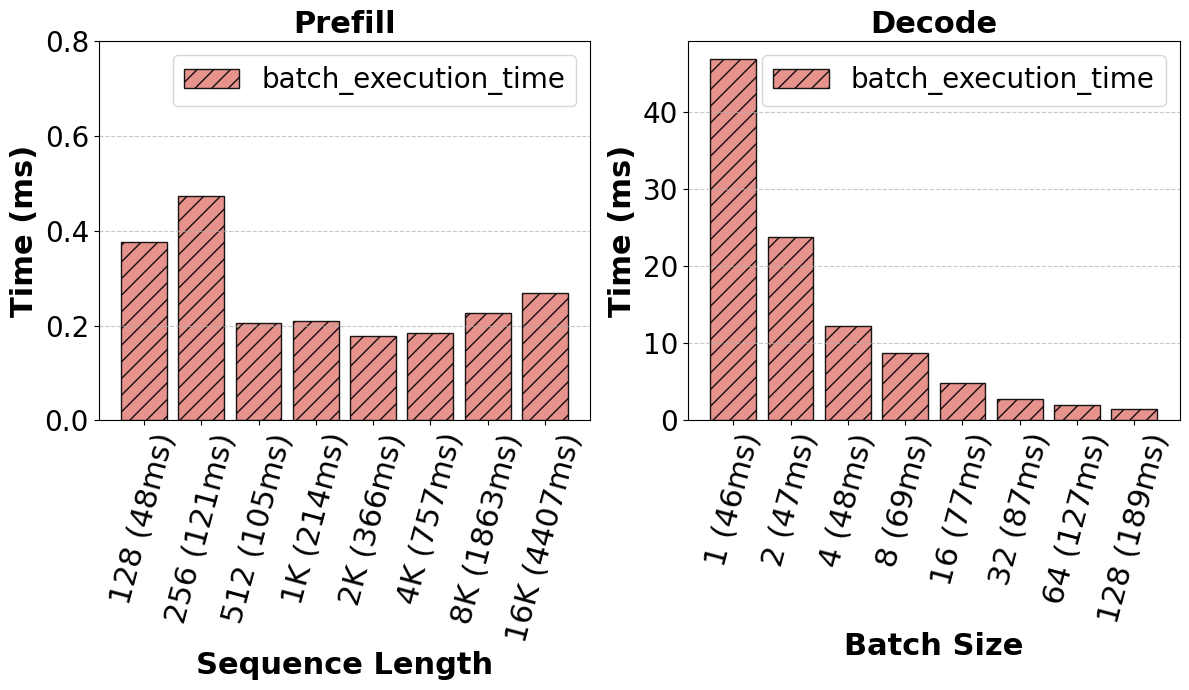

In [144]:
plot()